In [1]:
# VGG16 Fine-Tuning

# import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# data transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
}


In [3]:
# load data
os.chdir(r"C:\Users\siona\Downloads")
train_data = datasets.ImageFolder("exotic/train", transform=data_transforms["train"])
val_data   = datasets.ImageFolder("exotic/valid", transform=data_transforms["val"])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=8, shuffle=False)

class_names = train_data.classes


In [4]:
# load pretrained model
model = models.vgg16(weights="IMAGENET1K_V1")

# freeze features
for param in model.features.parameters():
    param.requires_grad = False
for param in model.features[-5:].parameters():
    param.requires_grad = True

# replace classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))


In [12]:
# send to device
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  

# train loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs,1)
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return model


dataloaders = {"train":train_loader,"val":val_loader}
model = train_model(model, dataloaders, criterion, optimizer)

Epoch 1/2
train Loss: 0.1488 Acc: 0.9400
val Loss: 0.2819 Acc: 0.8900
Epoch 2/2
train Loss: 0.0345 Acc: 0.9900
val Loss: 0.6734 Acc: 0.8900


In [13]:
# save fine-tuned model
torch.save(model.state_dict(), "vgg16_finetuned.pth")

gorilla


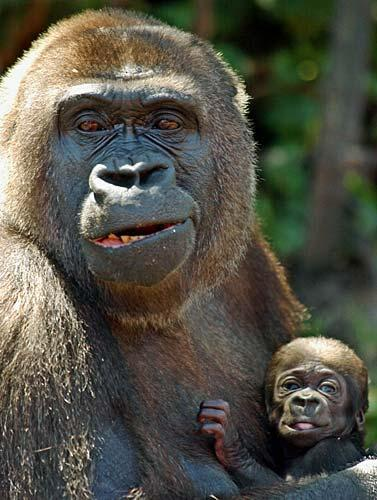

In [14]:
# prediction function
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0).to(device)
    outputs = model(img_tensor)
    _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

print(predict_image("test_animal.jpg", model, class_names))

# load image test image
image_path = r"test_animal.jpg"
image = Image.open(image_path).convert("RGB")
display(image)